In [11]:
from sklearn.datasets import fetch_openml
import numpy as np

# Fetch the MNIST dataset (70000 images of 28x28)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Features and labels
X = mnist['data']
y = mnist['target'].astype(np.int8)  # Convert string labels to integers

# Normalize pixel values to range [0, 1]
X = X / 255.0

print("Dataset shape:", X.shape)     # Should be (70000, 784)
print("Label distribution:", np.bincount(y))

C:\Users\Sharnav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset shape: (70000, 784)
Label distribution: [6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


In [28]:
# Set parameters
n_clusters = 10
n_features = X.shape[1]    # 784 features for 28x28 images
epochs = 10                 # number of epochs to train (iterations over dataset)
initial_lr = 1
final_lr = 0.1

# Initialize weight vectors for 10 neurons (e.g., random samples from X)
rng = np.random.default_rng(seed=42)
initial_indices = rng.choice(X.shape[0], size=n_clusters, replace=False)
W = X[initial_indices].copy()
# (Alternatively: W = rng.random((n_clusters, n_features)), for purely random init)

# Training the competitive network (winner-take-all)
for epoch in range(1, epochs+1):
    # Linearly decay learning rate from initial_lr to final_lr
    lr = initial_lr + (final_lr - initial_lr) * ((epoch-1) / (epochs-1))
    # Shuffle data order for this epoch
    indices = rng.permutation(X.shape[0])
    for idx in indices:
        x = X[idx]
        # Compute distances from this input to each neuron's weight vector
        # Using Euclidean distance
        distances = np.linalg.norm(W - x, axis=1)  # shape (10,)
        winner = np.argmin(distances)
        # Update winner neuron’s weights towards the input
        W[winner] += lr * (x - W[winner])
    # Compute average distance for monitoring
    avg_dist = np.mean([np.min(np.linalg.norm(W - x, axis=1)) for x in X])
    print(f"Epoch {epoch}/{epochs} - learning rate {lr:.2f}, average min distance {avg_dist:.4f}")

Epoch 1/10 - learning rate 1.00, average min distance 9.0245
Epoch 2/10 - learning rate 0.90, average min distance 7.9152
Epoch 3/10 - learning rate 0.80, average min distance 7.9391
Epoch 4/10 - learning rate 0.70, average min distance 7.6817
Epoch 5/10 - learning rate 0.60, average min distance 7.4008
Epoch 6/10 - learning rate 0.50, average min distance 7.0558
Epoch 7/10 - learning rate 0.40, average min distance 6.9288
Epoch 8/10 - learning rate 0.30, average min distance 6.7171
Epoch 9/10 - learning rate 0.20, average min distance 6.5195
Epoch 10/10 - learning rate 0.10, average min distance 6.3250


In [29]:
# Assign each image to the nearest prototype (cluster)
cluster_assignments = np.argmin(np.linalg.norm(W[None, :] - X[:, None], axis=2), axis=1)
# cluster_assignments[i] is index of closest neuron for image i

# Calculate distribution of true labels in each cluster
cluster_label_counts = np.zeros((n_clusters, 10), dtype=int)
for label, cluster in zip(y, cluster_assignments):
    cluster_label_counts[cluster, label] += 1

cluster_counts = []

# Print out the distribution of labels per cluster
for j in range(n_clusters):
    counts = cluster_label_counts[j]
    cluster_counts.append(counts)
    dominant_label = np.argmax(counts)
    print(f"Cluster {j}: {counts} -> dominant label {dominant_label}")


Cluster 0: [ 583    6  297 4795   17 2486  117   23 1461  127] -> dominant label 3
Cluster 1: [  32   15 4491  197   37    8  212   15   35   16] -> dominant label 2
Cluster 2: [  37   25  253  603   50  793   10   84 3931   89] -> dominant label 8
Cluster 3: [   6 4389  437  679  255  316  275  691  394  490] -> dominant label 1
Cluster 4: [ 246    2  138   27  190   38 3186    6  112   44] -> dominant label 6
Cluster 5: [  19    5   71   51 2094  488    6 4201  123 2506] -> dominant label 7
Cluster 6: [4635    0   71   20    1   35   35   16   19   37] -> dominant label 0
Cluster 7: [   2 3407  352   23  220  248   47  290  160   82] -> dominant label 1
Cluster 8: [  81   23  359  292 3789  432  614 1961  419 3547] -> dominant label 4
Cluster 9: [1262    5  521  454  171 1469 2374    6  171   20] -> dominant label 6


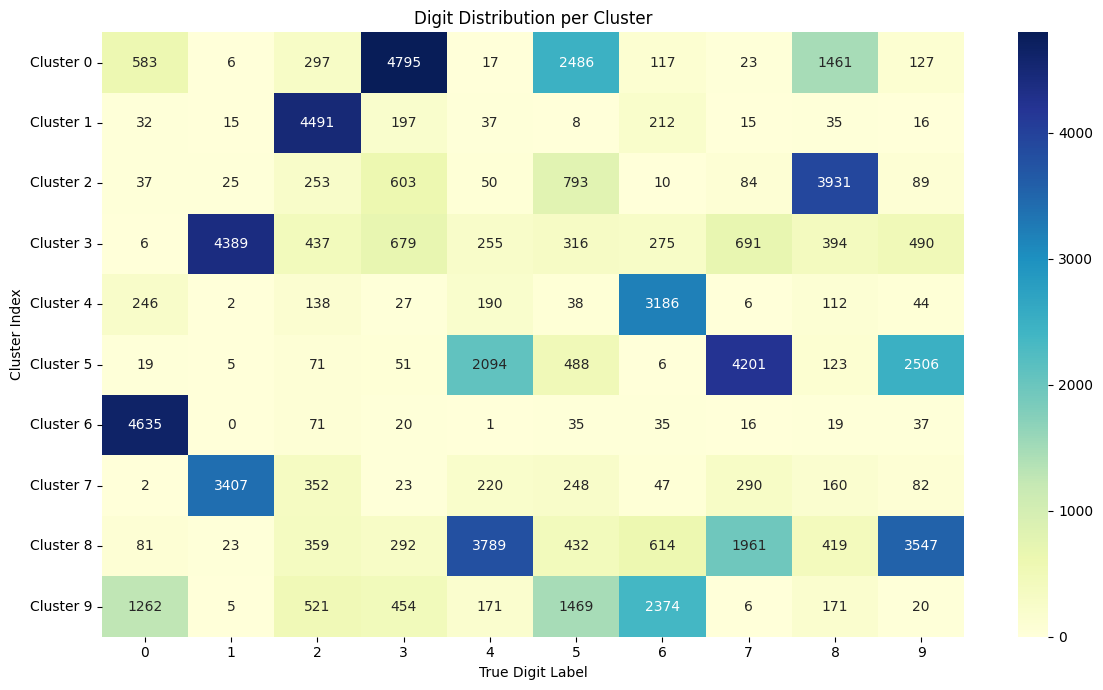

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_label_counts = np.array(cluster_counts)

plt.figure(figsize=(12, 7))
sns.heatmap(cluster_label_counts, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[f"Cluster {i}" for i in range(10)])
plt.xlabel("True Digit Label")
plt.ylabel("Cluster Index")
plt.title("Digit Distribution per Cluster")
plt.tight_layout()
plt.show()

Cluster Prototypes (Neuron Weights as Images)


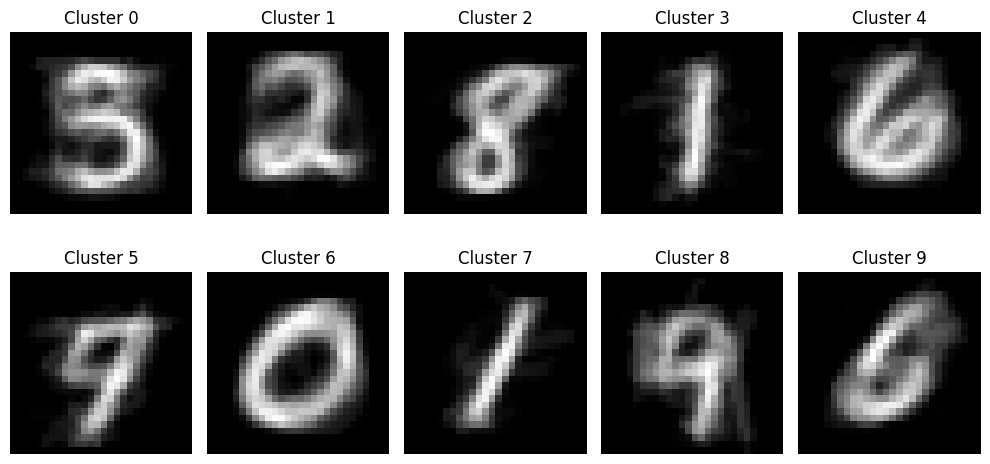

In [31]:
# Reshape each neuron's weights into 28x28 images
images = W.reshape(10, 28, 28)

# Plot the 10 prototype images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
print("Cluster Prototypes (Neuron Weights as Images)")
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=1)
plt.show()
